In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define

**Import packages**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
import xgboost as xgb


Using TensorFlow backend.


# DISCOVER Data

In [0]:
link = '/content/drive/My Drive/Colab Notebooks/train_features.csv'
link2 = '/content/drive/My Drive/Colab Notebooks/train_salaries.csv'
train_features = pd.read_csv(link)
train_salaries = pd.read_csv(link2)


Target

In [0]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


Features

In [0]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


Merging 2 data frames

In [0]:
merged_data = pd.merge(train_features,train_salaries,how='inner', on='jobId')

Ckecking for any duplicate data

In [0]:

len(merged_data[merged_data.duplicated()])


0

Removing jobid coulmn as it is unique for individual


In [0]:
merged_data = merged_data.drop('jobId', axis = 1)

Checking for any odd values in numeric data

In [0]:
merged_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


Looks like salary column is having some salaries as 0. This is odd, have to look deeply into the reasons.

In [0]:
Salary_Zero =  merged_data[merged_data.salary== 0]
Salary_Zero

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


These are the only 5 rows that are having salaries as 0. Looking at their degrees and jobtypes, we can remove this data as bad data.

In [0]:
merged_data = merged_data[merged_data.salary != 0]

Visualizing target variable

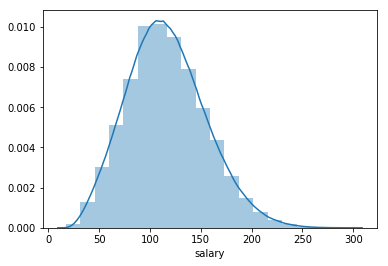

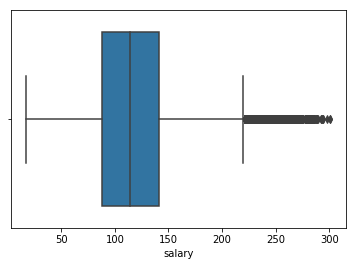

In [0]:
sns.distplot(merged_data.salary, bins=20)
plt.show()
sns.boxplot(merged_data.salary)
plt.show()

From the box plot it looks like there are some outliers in salaries.

Removing outliers using upper/lower limts from Inter Quartile range calculation

In [0]:
results = merged_data.salary.describe()
InterQuartileRange = results['75%'] - results['25%']
Upperlimit = results['75%'] +( 1.5 * InterQuartileRange )
lowerlimit = results['25%'] - ( 1.5 * InterQuartileRange )
print("Upperlimit:",Upperlimit,"lowerlimit:", lowerlimit)


Upperlimit: 220.5 lowerlimit: 8.5


We will look at the jobs of people having salaries greater than 220.5

In [0]:
merged_data[merged_data.salary > 220.5]['jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

Most of the people are in C-Suite as expected but there are some Junior positions having salaries >220k. We will see which industries have junior positions with 220k + salaries

In [0]:
merged_data[(merged_data.salary > 220.5) & (merged_data.jobType == 'JUNIOR')].industry.value_counts()

OIL        11
FINANCE     8
WEB         1
Name: industry, dtype: int64

Oil and finance industries are known for higher salaries so this data looks legitimate.

Now we will look at People having less than 8k salaries

In [0]:
merged_data[merged_data.salary < 8.5].jobType.value_counts()

Series([], Name: jobType, dtype: int64)

These doesn't look true. So we remove these records from data

In [0]:
merged_data = merged_data[merged_data.salary > 8.5]

Now we will look at Categorical data

In [0]:
merged_data.describe(include = ['O'])

,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995
unique,63,8,5,9,7
top,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,16193,125886,236975,532353,143205


In [0]:
merged_data[merged_data.degree == 'NONE'].jobType.value_counts()

JANITOR           62544
SENIOR            25117
MANAGER           25092
CEO               24898
CTO               24882
VICE_PRESIDENT    24825
JUNIOR            24781
CFO               24714
Name: jobType, dtype: int64

In [0]:
merged_data[merged_data.major == 'NONE'].jobType.value_counts()

JANITOR           124971
VICE_PRESIDENT     58463
SENIOR             58378
MANAGER            58288
CTO                58160
JUNIOR             58127
CEO                58024
CFO                57942
Name: jobType, dtype: int64

We can't remove records having major as none because >50% values are missing 

A function to automate several plots to see correlation of various features with target variable(salaries)

In [0]:
def  plots(df, column):
    if df[column].dtype.name == 'int64':
        sns.jointplot(column,'salary', data = df, kind= 'reg' ).annotate(stats.pearsonr)
        plt.show()
    else:
        
        plt.figure(figsize=(7, 6))
        sns.boxplot(column, 'salary', data = df)
        plt.show()
        
        plt.figure(figsize=(7, 6))
        value_counts = df[column].value_counts()
        no = np.arange(len(value_counts))
        plt.bar( no, value_counts)
        plt.xlabel(column, fontsize=10)
        plt.ylabel('value_counts', fontsize=10)
        plt.xticks(no, value_counts.index , fontsize=10, rotation=30)
        plt.title('Frequency')
        plt.show()

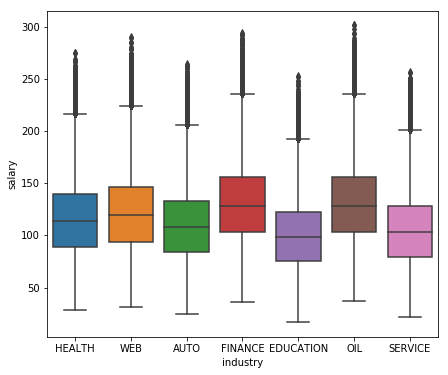

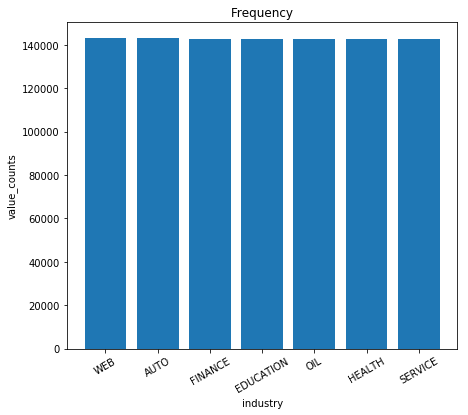

In [0]:
#Calling the function on different variables
plots(merged_data,'industry')

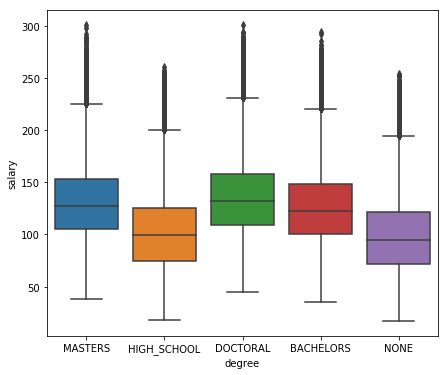

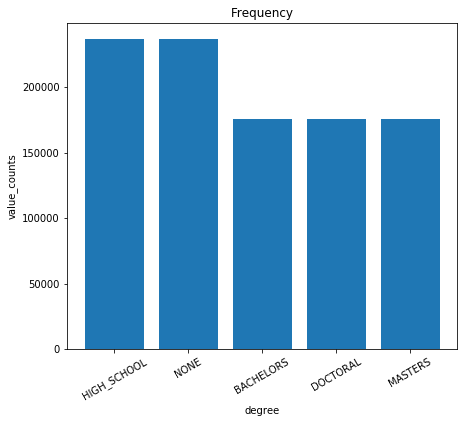

In [0]:
plots(merged_data,'degree')

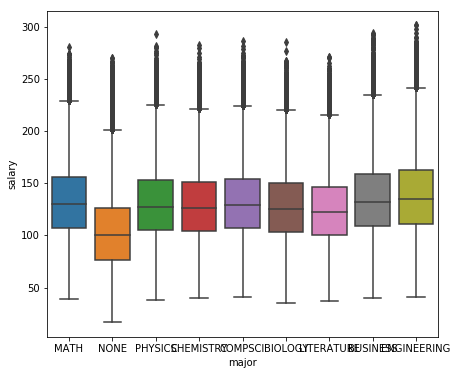

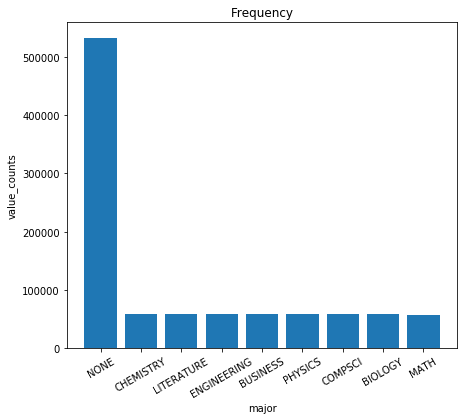

In [0]:
plots(merged_data,'major')

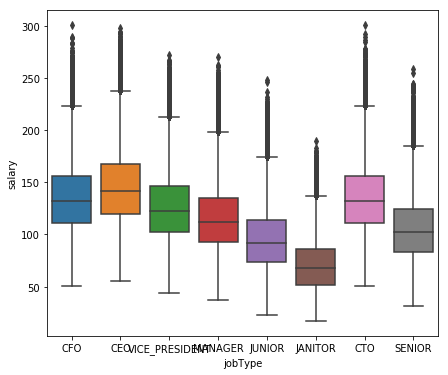

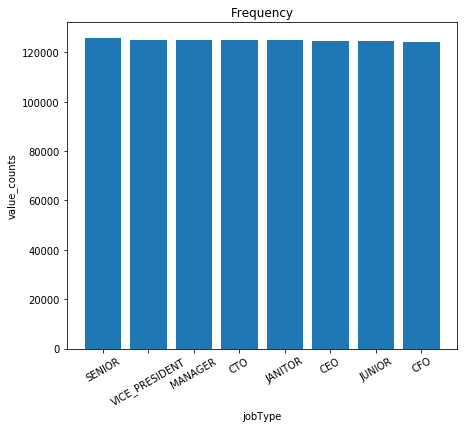

In [0]:

plots(merged_data,'jobType')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


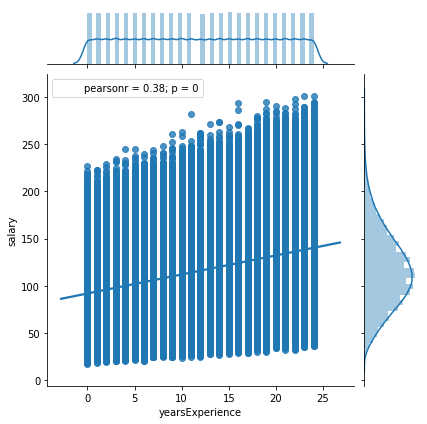

In [0]:
plots(merged_data,'yearsExperience')

It looks like People having different experience range are having different salaries, there are also some people with 0 experience earning very high salaries. There is 0.38 pearson correlation between salary and Years experience.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


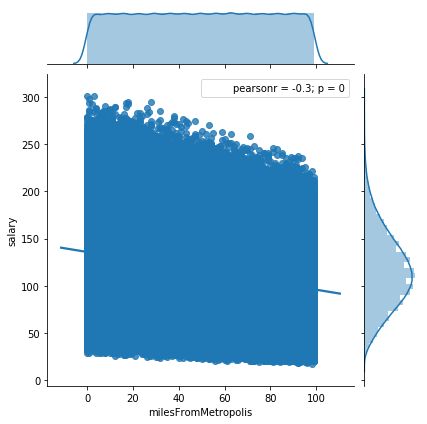

In [0]:
plots(merged_data,'milesFromMetropolis')

There is a negative correlation of -0.3. we can see from the above figure that, as miles from metropolis area increases , salary decreases.

We can create a heat map to observe correlations. For categorical data to see correlations i've encoded catogorical features with their respective average salaries

In [0]:
def label_encoding(df, column):
    #Convert to categorical
    df[column] = df[column].astype('category')
    #encode the categories using average salary for each category to replace label
    categorical_dict = {}
    Cat_Labels = df[column].cat.categories.tolist()
    for cat in Cat_Labels:
        categorical_dict[cat] = df[df[column] == cat]['salary'].mean()   
    df[col] = df[col].map(categorical_dict)

temp_data = merged_data.copy()
    
for col in temp_data.columns:
    if temp_data[col].dtype.name == "object":
        label_encoding(temp_data, col)

Correlations between features and salary can be seen from the heatmap.


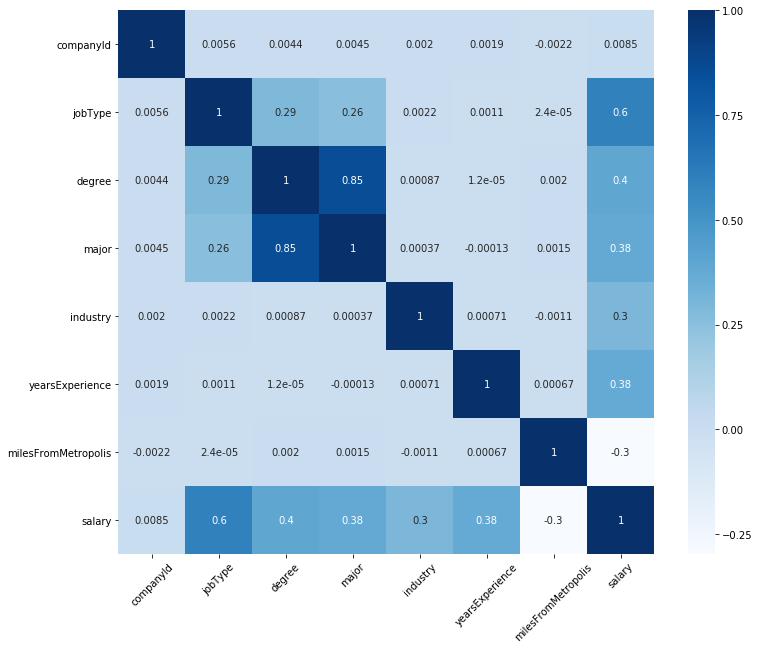

In [0]:
fig = plt.figure(figsize=(12, 10))
sns.heatmap(temp_data.corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

We have to Encode Categorical data for some of our models to work

Custom lable encoding(Ordinal encoding) for ordinal data

In [0]:
OE  = OrdinalEncoder(categories= [['JANITOR','JUNIOR','SENIOR','MANAGER','VICE_PRESIDENT','CFO','CTO','CEO']])
merged_data['jobType'] = OE.fit_transform(merged_data[['jobType']])

OE2  = OrdinalEncoder(categories= [["HIGH_SCHOOL", "NONE", "BACHELORS", "MASTERS","DOCTORAL"]])
merged_data['degree'] = OE2.fit_transform(merged_data[['degree']])


Lable encoding for nominal data

In [0]:
def LableEncode(columns,df):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
columns = ['companyId','major','industry']
LableEncode(columns,merged_data)

I want to create a function to create group statistics variables for our data to gain more signal from data. We groupby our data for all categorical variables and get salary statistics for that group as new variables.

In [0]:
#Columns to consider for groupby
col = ['companyId', 'jobType', 'degree', 'major', 'industry'] 

In [0]:
#Function to create group statistics dataframe 
def group_statistics(df, col, target = 'salary'):
     groups = df.groupby(col)
     group_stats = pd.DataFrame({'group_mean': groups[target].mean()})
     group_stats['group_max'] = groups[target].max()
     group_stats['group_min'] = groups[target].min()
     group_stats['group_median'] = groups[target].median()
     group_stats.reset_index(inplace=True)
     return group_stats
group_stats = group_statistics(merged_data,col,'salary') 

Merge 2 data frames by using left join and joining on categorical columns

In [0]:
merged_data = pd.merge(merged_data, group_stats, on = col, how='left')

Now our data is ready for predicition!!

Separating data into target and features.

In [0]:
# Splitting the dataset into the Training set and Test set
x = merged_data.drop('salary', axis = 1)
y = merged_data['salary']


Splitting the dataset into Test and train sets

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)


In [0]:
len(X_train.columns)

11

# Random Forest Model

Fitting base model without tuning

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,n_jobs = -1)
regressor.fit(X_train,y_train)

X_test = np.array(X_test)

# Predicting a new result
y_pred = regressor.predict(X_test)

#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)


339.0356263400887

**Hand tuning model for better hyper parameters**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

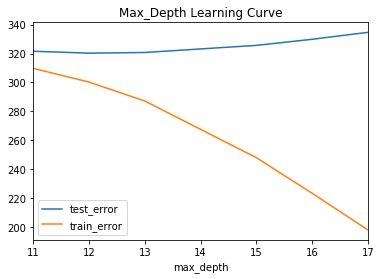

In [0]:
#Hyper paarmeter tuning
#Manually search for best max_depth
# Create empty array to store results
results = []
# Enumerate through different max_depth values and store results
for max_depth in [11,12,13,15,16,17]:
    RF = RandomForestRegressor(max_depth = max_depth,n_jobs = -1)
    RF.fit(X_train,y_train)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

# Plot Max_Depth Learning Curve
max_depth_lr.plot(title="Max_Depth Learning Curve")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

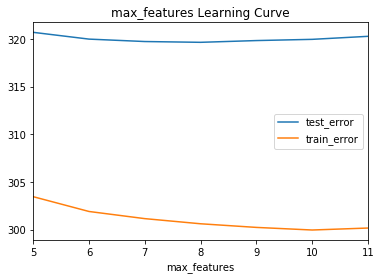

In [0]:
#Manually search for best max_features
results = []
for max_features in [5,6,7,8,9,10,11]:
    RF = RandomForestRegressor(max_features = max_features, max_depth  =12,n_jobs = -1)
    RF.fit(X_train,y_train)
    results.append(
        {
            'max_features': max_features,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

max_features_df = pd.DataFrame(results).set_index('max_features').sort_index()
max_features_df
max_features_df.plot(title="max_features Learning Curve")

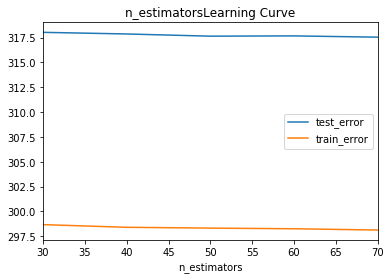

In [0]:

#For Best N_Estimators Parameter

results = []
for n_estimators in [30,40,50,60,70]:
    RF = RandomForestRegressor(n_estimators = n_estimators, max_depth  =12,max_features = 9,n_jobs = -1 )
    RF.fit(X_train,y_train)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

n_estimators_df = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_df
n_estimators_df.plot(title="n_estimatorsLearning Curve")

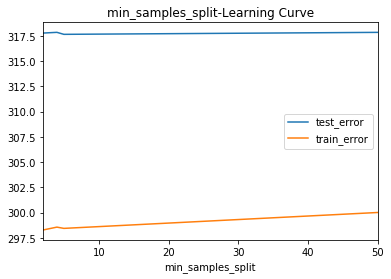

In [0]:

#For Best min_samples_split Parameter

results = []
for min_samples_split in [2,4,5,50]:
    RF = RandomForestRegressor(min_samples_split = min_samples_split, n_estimators = 40, max_depth  =12,max_features = 9,n_jobs = -1 )
    RF.fit(X_train,y_train)
    results.append(
        {
            'min_samples_split': min_samples_split,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

min_samples_split_df = pd.DataFrame(results).set_index('min_samples_split').sort_index()
min_samples_split_df
min_samples_split_df.plot(title="min_samples_split-Learning Curve")

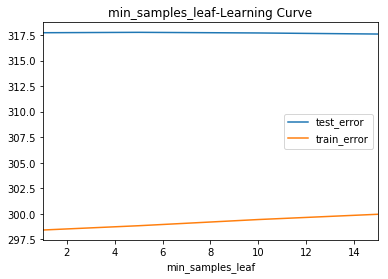

In [0]:
#For Best min_samples_leaf Parameter

results = []
for min_samples_leaf in [1,5,10,15]:
    RF = RandomForestRegressor(min_samples_leaf = min_samples_leaf,n_estimators = 40, max_depth  =12,max_features = 9,min_samples_split=3,n_jobs = -1 )
    RF.fit(X_train,y_train)
    results.append(
        {
            'min_samples_leaf': min_samples_leaf,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

min_samples_leaf_df = pd.DataFrame(results).set_index('min_samples_leaf').sort_index()
min_samples_leaf_df
min_samples_leaf_df.plot(title="min_samples_leaf-Learning Curve")

Using the results obtained from individual tuning now we will implement Grid search to get even better hyper parameters for Random forest


In [0]:
#Performing GridSearchCV
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(n_jobs = -1)
# Define Parameters
param_grid = {"max_depth": [11,12,13],
              "n_estimators": [20],
              "max_features": [8,9,10],
              "min_samples_split": [5],
              "min_samples_leaf":[5],
              "bootstrap": [True, False]}
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, n_jobs=-1 ).fit(X_train, y_train)


NameError: ignored

In [0]:
gs_cv.best_params_ 

NameError: ignored

In [0]:
best_model = gs_cv.best_estimator_ 
best_model


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [0]:
best_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
best_model.fit(X_train,y_train)

# Predicting a new result'
X_test = np.array(X_test)
y_pred = best_model.predict(X_test)

#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

366.5226547744976

# Neural Networks


 **Feature Scaling**

In [0]:

Predictors = (X_train).values
target = (y_train).values.reshape(-1, 1)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
sc_test_x = StandardScaler()
sc_test_y = StandardScaler()
Predictors = sc_X.fit_transform(Predictors)
target = sc_y.fit_transform(target)
X_test_scaled = sc_test_x.fit_transform((X_test).values)
y_test_scaled = sc_test_y.fit_transform(y_test.values.reshape(-1, 1))


In [0]:
early_stopping_monitor = EarlyStopping(patience=3)
n_cols = Predictors.shape[1]
model = Sequential()
model.add(Dense(200,activation='relu',input_shape = (n_cols,)))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(Predictors,target,validation_split = 0.3, epochs = 30, callbacks = [early_stopping_monitor])









Train on 524997 samples, validate on 224999 samples
Epoch 1/30





524997/524997 [==============================] - 125s 238us/step - loss: 0.2503 - val_loss: 0.2440
Epoch 2/30
524997/524997 [==============================] - 119s 226us/step - loss: 0.2439 - val_loss: 0.2432
Epoch 3/30
524997/524997 [==============================] - 120s 228us/step - loss: 0.2423 - val_loss: 0.2395
Epoch 4/30
524997/524997 [==============================] - 119s 226us/step - loss: 0.2415 - val_loss: 0.2437
Epoch 5/30
524997/524997 [==============================] - 119s 227us/step - loss: 0.2410 - val_loss: 0.2397
Epoch 6/30
524997/524997 [==============================] - 119s 226us/step - loss: 0.2407 - val_loss: 0.2403


In [0]:
predictions_scaled = model.predict(X_test_scaled)
predictions = sc_test_y.inverse_transform(predictions_scaled)

MSE_Neural_network = mean_squared_error(y_test,predictions)
print('MSE_Neural_network',MSE_Neural_network)

MSE_Neural_network 361.3776551515691


# XGBoost

** Base model without tuning**

In [0]:

XGBoost = xgb.XGBRegressor()
XGBoost.fit(X_train, y_train)
predictions = XGBoost.predict(X_test)
XGBoost.get_params()
MSE_Neural_network = mean_squared_error(y_test,predictions)
print('MSE_Neural_network',MSE_Neural_network)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE_Neural_network 367.6388870568415


**Random search of parameters, using 3 fold cross validation, 
searching across 50 different combinations, and using all available cores**

In [0]:
# Number of trees in XGBoost
n_estimators = [50, 100, 150, 200 , 250]
# gamma parameter
gamma = [0,1,5]
# max depth of the tree
max_depth = [3,5,10,15,20]
# no of variables that are being used in tree
colsample_bytree = [0.3,0.5,0.8]
# Minimum number of samples required at each leaf node
subsample = [0.8,0.9,1]
# learning rate for gradient descent
learning_rate = [0.01,0.03,0.05,0.1]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'gamma': gamma,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample,
               'learning_rate': learning_rate}

rf_random = RandomizedSearchCV(estimator = XGBoost, param_distributions = random_grid, n_iter = 50, cv = 3,random_state=42, n_jobs = -1)
best_xgboost_model = rf_random.best_estimator_

In [0]:
best_xgboost_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [0]:
# Fit the random search model
best_xgboost_model.fit(X_train, y_train)

# Make predictions with test data
predictions = best_xgboost_model.predict(X_test)

MSE_XGBoost = mean_squared_error(y_test,predictions)
print('MSE_XGBoost',MSE_XGBoost)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE_XGBoost 357.59193654134424


**Basic feature importance chart**

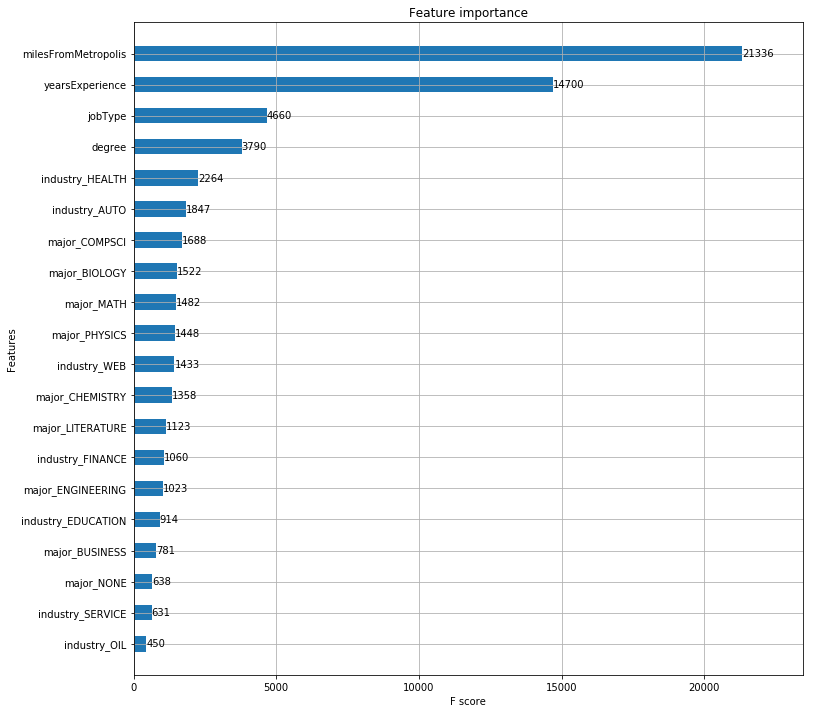

In [0]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(best_xgboost_model, height=0.5, ax=ax)
plt.show()